# TensorFlow Linear Regression

### This implementation uses TensorFlow/Keras to build a linear regression model

### Goal: Predict used car prices and compare with No-Framework, Scikit-Learn, and PyTorch

What TensorFlow/Keras provides (that we built manually in No-Framework):
- `tf.keras.Sequential`: High-level API for building models layer by layer
- `tf.keras.layers.Dense`: Fully connected layer (replaces manual weights + bias)
- `tf.keras.losses.MeanSquaredError`: Pre-built loss function
- `tf.keras.optimizers.SGD`: Optimizer that handles parameter updates
- `model.fit()`: Complete training loop in one line

Key Concept - Keras vs Raw TensorFlow:
- TensorFlow 2.x uses Keras as its high-level API
- Keras abstracts away the computational graph complexity
- Similar to PyTorch's nn.Module, but with even simpler syntax via Sequential API


In [1]:
# tensorflow: The main TensorFlow Library
import tensorflow as tf

# numpy: Still needed for initial data handling
import numpy as np

# pandas: For loading CSV data
import pandas as pd

# matplotlib: for visualizations
import matplotlib.pyplot as plt

# os: File path handling
import os

# Sklearn utilities: Using these for consistency with previous implementations
# This ensures identical train/test splits and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Performance tracking
import time
import tracemalloc
import platform

# Set random see for reproducibility
RANDOM_SEED = 113
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("All Imports successful!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Random seed set to: {RANDOM_SEED}")

All Imports successful!
TensorFlow version: 2.20.0
Random seed set to: 113


# Load Cleaned Data

- Load the same pre-processed dataset used in N0-Framework, Scikit-Learn, and PyTorch
- Using pandas for consistency with SL implementation
- This ensures fair comparison across all frameworks

In [2]:
# Define path to our cleaned dataset
DATA_PATH = os.path.join('..', '..', 'data', 'processed', 'vehicles_clean.csv')

# Load data using pandas
df = pd.read_csv(DATA_PATH)

# Verify data loaded correctly
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df.head(3))

Dataset shape: (100000, 12)
Columns: ['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'state']

First 3 rows:
   price    year  manufacturer  condition  cylinders  fuel  odometer  \
0  29990  2014.0             7          2          6     2   26129.0   
1   6995  2006.0            12          0          6     2  198947.0   
2   4995  2009.0            35          6          8     2  152794.0   

   title_status  transmission  drive  type  state  
0             0             2      0     8     17  
1             6             0      3    10      5  
2             0             0      3    11     22  


# Separate Features and Target

- Price is our TARGET variable 
- All other columns are FEATURES
- Same seperation as Scikit-Learn implementation

In [3]:
# Define target and column variable (same as all previous implementations)
TARGET_COLUMN = 'price'
FEATURE_COLUMNS = [ 'year', 'manufacturer', 'condition', 'cylinders',
                    'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'state']

# Extract target (y) and features (X) as numpy arrays
y = df[TARGET_COLUMN].values
X = df[FEATURE_COLUMNS].values

# Store feature names for later use (displaying learned weights)
FEATURE_NAMES = FEATURE_COLUMNS

# Verify shapes 
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nFeature Names: {FEATURE_NAMES}")

Features (X) shape: (100000, 11)
Target (y) shape: (100000,)

Feature Names: ['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'state']


# Train/Test Split

- Using Sklearn's train_test_split for consistency with Scikit-learn implementation
- Same 80/20 split, same random seed (113)
- This ensures we're comparing apples-to-applies across frameworks

In [4]:
# Split data using sklearn (same as Scikit-Learn and PyTorch Implementations)
X_train, X_test, y_train, y_test = train_test_split(
    X,                          # Features to split
    y,                          # Target to split
    test_size=0.2,              # 20% for testing, 80% for training
    random_state=RANDOM_SEED    # Seed 113 for reporoducibility
)

# Verify split sizes
print(f"Training set size: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set size: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Training set size: 80,000 samples (80%)
Test set size: 20,000 samples (20%)

X_train shape: (80000, 11)
X_test shape: (20000, 11)
y_train shape: (80000,)
y_test shape: (20000,)


# Feature Scaling (Z-Score Normalization)

- Using sklearn's StandardScaler for consistency with Scikit-Learn implementation
- Same z-score noramlization
- Fit on training data only, transform both train and test

In [5]:
# Create and fit scaler on training data (same as Scikit-Learn)
scaler = StandardScaler()

# fit_transform on training data: calculates mean/std AND applies scaling
X_train_scaled = scaler.fit_transform(X_train)

# transform on test data: uses mean/std from training (no data leakage)
X_test_scaled = scaler.transform(X_test)

# Display the learned scaling parameters
print("Scaling parameters (computed from training data):\n")
print(f"{'Feature':<15} {'Mean':>15} {'Std':>15}")
print("-" * 47)
for i, name in enumerate(FEATURE_NAMES):
    print(f"{name:<15} {scaler.mean_[i]:>15.2f} {scaler.scale_[i]:>15.2f}")

# Verify scaling worked - training data should have mean=0 and std=1
print("\n--- Verification (Training Data After Scaling) ---")
print(f"Mean of each feature (should be 0): {np.mean(X_train_scaled, axis=0).round(6)}")
print(f"Std of each feature (should be 1): {np.std(X_train_scaled, axis=0).round(6)}")

Scaling parameters (computed from training data):

Feature                    Mean             Std
-----------------------------------------------
year                    2012.32            5.79
manufacturer              18.24           11.48
condition                  3.09            2.43
cylinders                  6.00            1.92
fuel                       2.05            0.78
odometer               94235.84        62977.76
title_status               0.23            1.06
transmission               0.39            0.77
drive                      1.40            1.21
type                       7.14            4.12
state                     23.60           15.10

--- Verification (Training Data After Scaling) ---
Mean of each feature (should be 0): [ 0.  0.  0. -0.  0. -0. -0.  0.  0. -0. -0.]
Std of each feature (should be 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Start Performance Tracking

- Begin measuring time and memory BEFORE model initialization
- This captures model creation, compilation, and training
- Matches the timing approachf used in No-Framework and PyTorch

In [6]:
# Start memory tracking
tracemalloc.start()

# Record start time
start_time = time.time()

print("Performance tracking started...")
print(" - Memory tracking: ACTIVE")
print(" - Time: STARTED")

Performance tracking started...
 - Memory tracking: ACTIVE
 - Time: STARTED


# Define the Model

TensorFlow uses Keras as its high-level API. For linear regression, we use:
- `tf.keras.Sequential`: Container for stacking layers linearly
- `tf.keras.layers.Dense`: Fully connected layer (like PyTorch's nn.Linear)

| TensorFlow/Keras | PyTorch Equivalent | No-Framework Equivalent |
|------------------|-------------------|------------------------|
| `Sequential([Dense(1)])` | `nn.Linear(11, 1)` | `weights = np.zeros(11)` + `bias = 0` |
| `model(X)` | `model(X)` | `X @ weights + bias` |
| `model.get_weights()` | `model.parameters()` | Manual weight/bias variables |


In [7]:
# Define the model

# tf.keras.Sequential creates a model by stacking layers in order
# For linear regression, we need just one Dense layer with 1 output

# Dense layer parameters:
# - units=1: One output
# - input_shape=(11,): 11 input features
# - Automatically creates weights (11,) and bias (1,)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(11,)),
    tf.keras.layers.Dense(units=1)
])

# Displayu model architecture
print("Model Architecture:")
model.summary()

# View initial weights (randomly initialized by default)
# get_weights() returns [weights_array, bias_array]
weights, bias = model.get_weights()
print(f"\nInitial Weights shape: {weights.shape}")
print(f"Initial Bias shape: {bias.shape}")
print(f"\nInitial weights (first 5): {weights[:5, 0]}")
print(f"Initial Bias: {bias}")

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)


Initial Weights shape: (11, 1)
Initial Bias shape: (1,)

Initial weights (first 5): [-0.2585576  -0.309238    0.3571977   0.1964016  -0.40798283]
Initial Bias: [0.]


# Compile the Model

TensorFlow requires a separate `compile()` step before training. This configures:
- **Loss function**: What to minimize (MSE for regression)
- **Optimizer**: How to minimize it (SGD with learning rate 0.01)

| TensorFlow | PyTorch Equivalent |
|------------|-------------------|
| `model.compile(loss, optimizer)` | Separate `criterion` and `optimizer` objects |
| Configured once before training | Used explicitly in training loop |


In [8]:
# Compile the model

# mode.compile() configures the model for training
# This is required BEFORE calling model.fit()

# Parameters:
# - Optimizer: SGD with learning_rate=0.01
# - loss: Mean Squared Error

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss='mse'
)

print("Model compiled successfully!")
print(" Optimizer: SGD (learning_rate=0.01)")
print(" Loss function: Mean Squared Error (MSE)")

Model compiled successfully!
 Optimizer: SGD (learning_rate=0.01)
 Loss function: Mean Squared Error (MSE)


# Train the Model

TensorFlow's `model.fit()` handles the ENTIRE training loop in one line:
- Forward pass
- Loss computation
- Backward pass (gradient computation)
- Weight updates

| TensorFlow | PyTorch Equivalent | No-Framework Equivalent |
|------------|-------------------|------------------------|
| `model.fit(X, y, epochs=1000)` | Manual for loop (1000 iterations) | Manual for loop (1000 iterations) |
| ~1 line | ~15 lines | ~30 lines |

The `history` object returned by `fit()` contains loss values for plotting.


In [9]:
# Train the model

# model.fit() performs the entire training loop:
#   1. Forward pass (predictions)
#   2. Loss computation (MSE)
#   3. Backward pass (gradients via automatic differentiation)
#   4. Weight updates (SGD optimizer step)
# All in one line of code

# Parameters:
#   - X_train_scaled: Input features (scaled)
#   - y_train: Target values
#   - epochs: Numer of training iterations (1000, same as previous frameworks)
#   - batch_size: Use full dataset per epoch (same as previous frameworks)
#   - verbose: 0=silent, 1=progress bar, 2= one line per epoch
#   - shuffle: False to match our other implementations

print("Training Linear Regression Model...")

# Train the model - this replaces the entire manual training loop
history = model.fit(
    X_train_scaled,         # Input features
    y_train,                # Target values
    epochs=1000,            # Same as previous frameworks
    batch_size=len(X_train),# Full batch per epoch
    verbose=0,              # Silent training - printing summary after
    shuffle=False           # Don't shuffle to match other frameworks
)

# STOP Performance tracking
end_time = time.time()
current_mem, peak_mem = tracemalloc.get_traced_memory()

# Calculate performance metrics
training_time = end_time - start_time
peak_memory_mb = peak_mem / 1024 / 1024

print("=" * 50)
print("Training Complete!")
print(f"  Initial Loss: {history.history['loss'][0]:,.2f}")
print(f"  Final Loss:   {history.history['loss'][-1]:,.2f}")
print(f"\n--- Training Performance ---")
print(f"  Training time: {training_time:.4f} seconds")
print(f"  Peak memory:   {peak_memory_mb:.2f} MB")

Training Linear Regression Model...
Training Complete!
  Initial Loss: 569,587,456.00
  Final Loss:   101,652,944.00

--- Training Performance ---
  Training time: 23.5790 seconds
  Peak memory:   8.37 MB


# Evaluation

TensorFlow's `model.predict()` handles inference automatically:
- No need for `torch.no_grad()` context manager
- Returns NumPy array directly (no tensor conversion need)

We calculate the same metrics (MSE, RMSE, R^2) for comparison with all frameworks.

In [10]:
# Evaluation

# model.predict() performs inference (forward pass only, no graidnets)
# Unlike PyTorch, TensorFlow returns Numpy arrays directly

# Make predictions on test set
y_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate evaluation metrics

# MSE
mse = np.mean((y_pred - y_test) ** 2)

# RMSE
rmse = np.sqrt(mse)

# R^2
ss_res = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Display results
print("=" * 50)
print("MODEL EVALUATION (Test Set)")
print("=" * 50)
print(f"  Mean Squared Error:       {mse:,.2f}")
print(f"  Root Mean Squared Error:  ${rmse:,.2f}")
print(f"  R² Score:                 {r2:.4f}")
print()
print("Comparison with All Implementations:")
print("-" * 70)
print(f"  {'Metric':<12} {'No-Framework':>14} {'Scikit-Learn':>14} {'PyTorch':>14} {'TensorFlow':>14}")
print(f"  {'-'*12} {'-'*14} {'-'*14} {'-'*14} {'-'*14}")
print(f"  {'RMSE':<12} {'$10,058':>14} {'$10,105':>14} {'$10,105':>14} {f'${rmse:,.0f}':>14}")
print(f"  {'R²':<12} {'0.4983':>14} {'0.4986':>14} {'0.4986':>14} {f'{r2:.4f}':>14}")

MODEL EVALUATION (Test Set)
  Mean Squared Error:       102,115,050.58
  Root Mean Squared Error:  $10,105.20
  R² Score:                 0.4986

Comparison with All Implementations:
----------------------------------------------------------------------
  Metric         No-Framework   Scikit-Learn        PyTorch     TensorFlow
  ------------ -------------- -------------- -------------- --------------
  RMSE                $10,058        $10,105        $10,105        $10,105
  R²                   0.4983         0.4986         0.4986         0.4986


# Visualizations

We create the same three visualizations as all previous implementations:
1. Cost Curve
2. Predictions vs Actual
3. Feature Importance

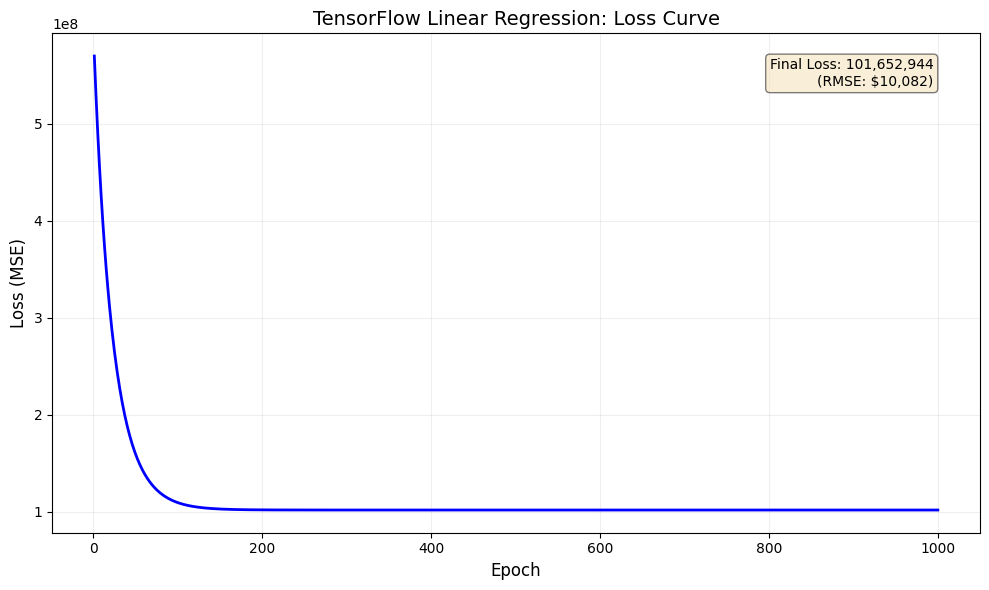

Saved: results/cost_curve.png


In [11]:
# VISUALIZATION 1: Cost Curve

# Create results directory
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Get loss history from object returned by model.fit()
loss_history = history.history['loss']

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, color='blue', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('TensorFlow Linear Regression: Loss Curve', fontsize=14)
plt.grid(True, alpha=0.2)

# Add annotation showing convergence
plt.annotate(
    f'Final Loss: {loss_history[-1]:,.0f}\n(RMSE: ${np.sqrt(loss_history[-1]):,.0f})',
    xy=(0.95, 0.95),
    xycoords='axes fraction',
    fontsize=10,
    ha='right',
    va='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

plt.tight_layout()
plt.savefig(f'{results_dir}/cost_curve.png', dpi=150)
plt.show()
print(f"Saved: {results_dir}/cost_curve.png")

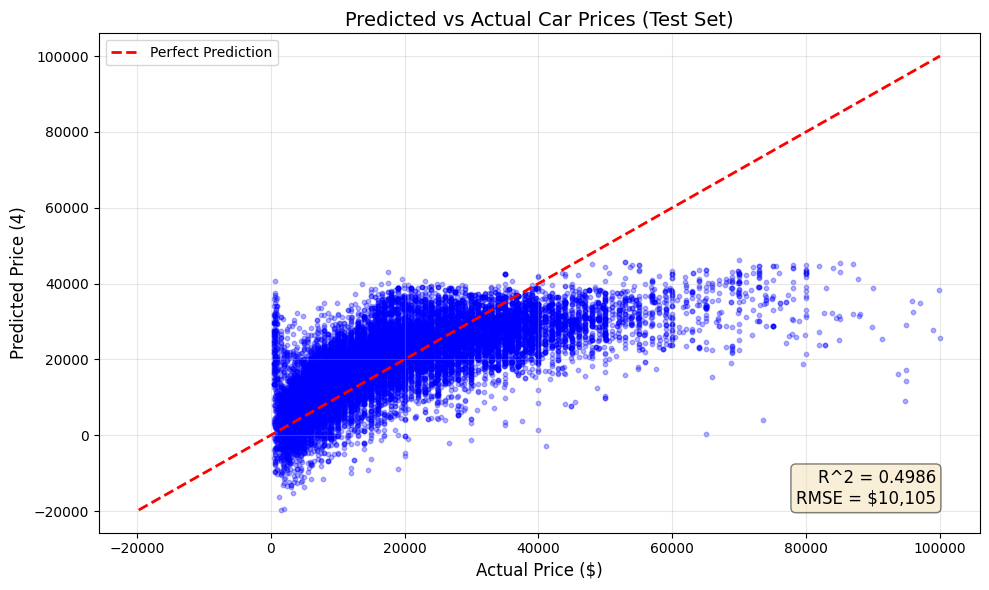

Saved results/predictions_vs_actual.png


In [12]:
# VISUALIZATION 2: Predictions vs Actual
plt.figure(figsize=(10, 6))

# Scatter plot of predicted vs actual values
plt.scatter(y_test, y_pred, alpha=0.3, color='blue', s=10)

# Perfect predicted line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price (4)', fontsize=12)
plt.title('Predicted vs Actual Car Prices (Test Set)', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Add R^2 and RMSE annotation in bottom-right corner
plt.annotate(f'R^2 = {r2:.4f}\nRMSE = ${rmse:,.0f}',
             xy=(0.95, 0.05), xycoords='axes fraction',
             fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{results_dir}/predictions_vs_actual.png', dpi=150)
plt.show()
print(f"Saved {results_dir}/predictions_vs_actual.png")

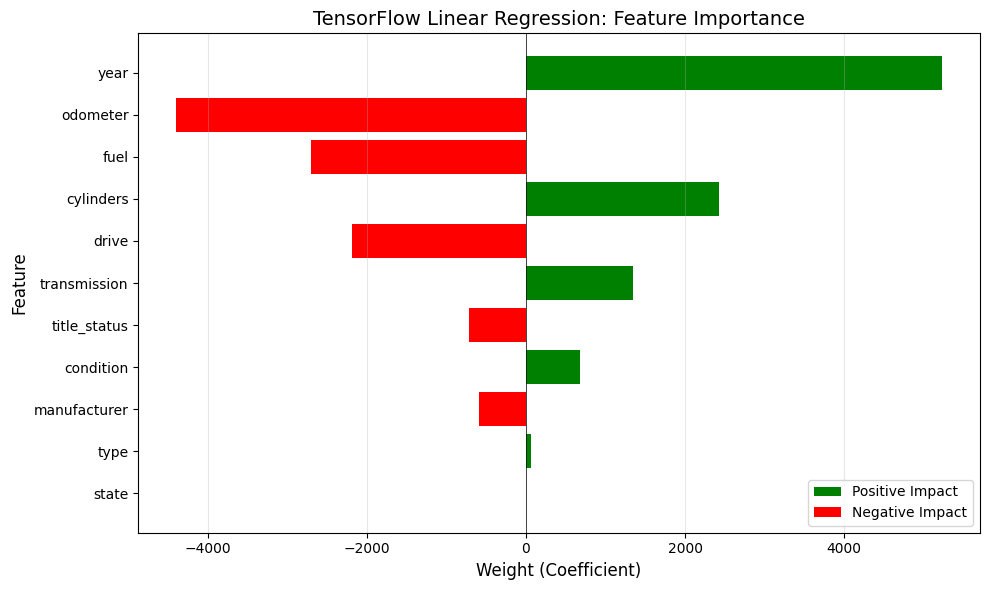

Saved: results/feature_importance.png


In [13]:
# VISUALIZATION 3: Feature Importance

# Extract weights from the TensorFlow model
weights, bias = model.get_weights()
weights = weights.flatten()

# Create dataframe for easier plotting
feature_importance = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'Weight': weights,
    'Abs_Weight': np.abs(weights)
}).sort_values('Abs_Weight', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
colors = ['green' if w > 0 else 'red' for w in feature_importance['Weight']]
plt.barh(feature_importance['Feature'], feature_importance['Weight'], color=colors)
plt.xlabel('Weight (Coefficient)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('TensorFlow Linear Regression: Feature Importance', fontsize=14)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Positive Impact'),
    Patch(facecolor='red', label='Negative Impact')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f'{results_dir}/feature_importance.png', dpi=150)
plt.show()
print(f"Saved: {results_dir}/feature_importance.png")


# Framework Comparison Summary

Final comparison of all four implementations for Lienar Regression on the same dataset

In [14]:
# Framework Comparison Summary

print("=" * 75)
print("FINAL FRAMEWORK COMPARISON: Linear Regression")
print("=" * 75)

print(f"\n{'Metric':<20} {'No-Framework':>15} {'Scikit-Learn':>15} {'PyTorch':>15} {'TensorFlow':>15}")
print("-" * 80)
print(f"{'Training Time':<20} {'0.3799 sec':>15} {'0.0258 sec':>15} {'3.4400 sec':>15} {f'{training_time:.4f} sec':>15}")
print(f"{'Peak Memory':<20} {'1.96 MB':>15} {'14.76 MB':>15} {'54.18 MB':>15} {f'{peak_memory_mb:.2f} MB':>15}")
print(f"{'Test RMSE':<20} {'$10,058':>15} {'$10,105':>15} {'$10,105':>15} {f'${rmse:,.0f}':>15}")
print(f"{'Test R²':<20} {'0.4983':>15} {'0.4986':>15} {'0.4986':>15} {f'{r2:.4f}':>15}")

print(f"\n--- System Information ---")
print(f"  Python version:  {platform.python_version()}")
print(f"  Processor:       {platform.processor()}")
print(f"  Machine:         {platform.machine()}")
print(f"  System:          {platform.system()} {platform.release()}")
print(f"  TensorFlow:      {tf.__version__}")

print(f"\n--- Key Insights ---")
print(f"  • Scikit-Learn: Fastest (Normal Equation) - best for simple linear regression")
print(f"  • No-Framework: Lowest memory, good for learning fundamentals")
print(f"  • PyTorch: Manual control, shines with neural networks")
print(f"  • TensorFlow: Highest abstraction (model.fit), production-oriented")
print(f"  • All frameworks achieve identical accuracy (R^2 ≈ 0.50)")

FINAL FRAMEWORK COMPARISON: Linear Regression

Metric                  No-Framework    Scikit-Learn         PyTorch      TensorFlow
--------------------------------------------------------------------------------
Training Time             0.3799 sec      0.0258 sec      3.4400 sec     23.5790 sec
Peak Memory                  1.96 MB        14.76 MB        54.18 MB         8.37 MB
Test RMSE                    $10,058         $10,105         $10,105         $10,105
Test R²                       0.4983          0.4986          0.4986          0.4986

--- System Information ---
  Python version:  3.12.2
  Processor:       Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
  Machine:         AMD64
  System:          Windows 11
  TensorFlow:      2.20.0

--- Key Insights ---
  • Scikit-Learn: Fastest (Normal Equation) - best for simple linear regression
  • No-Framework: Lowest memory, good for learning fundamentals
  • PyTorch: Manual control, shines with neural networks
  • TensorFlow: Hi